In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 设置研究区范围
Altay = ee.Geometry.Rectangle(86.5,46.5,88,48)
Map.addLayer(Altay,{'opacity': 0.5},'Altay')
Map.centerObject(Altay,6) 

In [4]:
roi = ee.Geometry.Point([87.21,47.19])
# roi = ee.Geometry.MultiPoint([[87.21,47.19],[87.4,46.91],[89.68,50.5],[89.82,50.34],[90.55,49.46],[85.74,48.77],[88.34,48.62],[88.57,48.53],[90.06,48.55],[90.99,50.11],[92.74,50.43],[93.37,49.13],[92.3,48.08],[93.19,48.07],[93.43,47.67]])
Map.addLayer(roi,{}, 'point')

In [5]:
# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def AWEIsh(image):
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    return image.addBands(awei)
def calculate_area(feature):
    return feature.set({'area': feature.geometry().area(1).divide(1e6)})


# landsat5 2003.01-2012.04

##  一些变量的自定义

In [6]:
# 设置影像的年份，可用年份为2003-2012
Year = 2003
# 定义一些变量
days_31 = [1,3,5,7,8,10,12]
days_30 = [4,6,9,11]
days_28 = [2]

bands5 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
bands8 = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

In [7]:
def cloudMaskL457(image):
    qa = image.select('pixel_qa')
    cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7)) \
                  .Or(qa.bitwiseAnd(1 << 3))
    mask2 = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(cloud.Not()).updateMask(mask2)
# # 移除无效像元
# def cloudMaskL457(image):
#     cloudShadowBitMask = (1 << 3)
#     cloudsBitMask = (1 << 5)
#     snowBitMask = (1 << 4)   
#     qa = image.select('pixel_qa')
#     mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
#                    .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
#                    .And(qa.bitwiseAnd(snowBitMask).eq(0))
#     return image.updateMask(mask)



visParams5 = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

visParams8 = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

## 显示每个月份landsat5 影像覆盖范围

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [85,46,94,51.5]  
region = [86.5,46.5,88,48] 

for month in range(1,13,1):
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(cloudMaskL457) 
    fig = plt.figure(figsize=(12, 8))
    altay_landsat = landsat_images.mosaic().clip(Altay)
    # 添加图层到Map中
    Map.addLayer(altay_landsat,visParams5,'Uvs image in {} month'.format(month))
    ax = cartoee.get_map(altay_landsat, region=region, vis_params=visParams5)
    cartoee.add_gridlines(ax, interval=[1,1], linestyle=":")
    ax.set_title(label = 'landsat5 images in {} /{}'.format(Year,month), fontsize=20)

##  计算在可用月份，湖泊的水体面积

In [ ]:
# 根据上一步，Landsat影像在湖泊上的覆盖范围，确定需要提取水体面积的月份
# 如：需要提取水体面积的月份为5，6，8月，则 yue = [5,6,8]
yue = [5,8,9,10]

In [ ]:
print('landsat5 {} Year: '.format(Year))
for month in yue:
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(cloudMaskL457) 
    altay_landsat = landsat_images.mosaic().clip(Altay).select(bands5).rename(bands8)
    Map.addLayer(altay_landsat,visParams8,'image in {} month'.format(month))
    altay_water = AWEIsh(altay_landsat).select('AWEI').gt(0).selfMask()
    Map.addLayer(altay_water,{'palette':['blue']},'altay water {}'.format(month))
    water_vector = altay_water.reduceToVectors(scale=30, maxPixels=1e9)
    altay_lake = water_vector.filterBounds(roi)
    Map.addLayer(altay_lake,{},"uvs {}".format(month))
    altay_waterarea = altay_lake.map(calculate_area)
    print('area:{} km² in {} month'.format(altay_waterarea.first().get('area').getInfo(),month))

In [ ]:
landsat5 2003 Year: 
area:866.9116988120967 km² in 5 month
area:846.4181798497243 km² in 8 month
area:848.4503838941101 km² in 9 month
area:850.3802974591837 km² in 10 month

# landsat7 2003.01-2020.12

##  一些变量的自定义

In [8]:
# 设置影像的年份，可用年份为2014-2020
Year = 2012
# 定义一些变量
days_31 = [1,3,5,7,8,10,12]
days_30 = [4,6,9,11]
days_28 = [2]

bands7 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
bands8 = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

In [9]:
def cloudMaskL457(image):
  qa = image.select('pixel_qa')
  cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7)) \
                  .Or(qa.bitwiseAnd(1 << 3))
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

visParams7 = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

visParams8 = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

## 显示每个月份landsat7影像覆盖范围

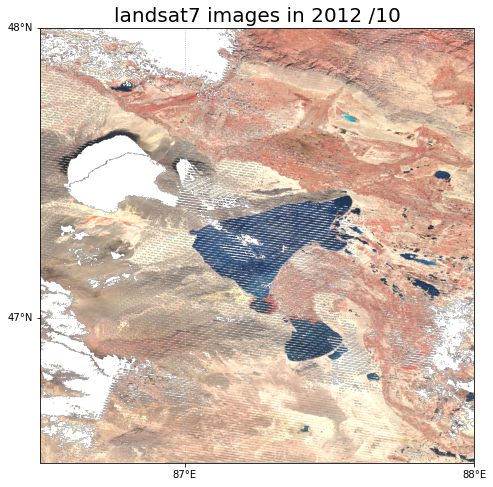

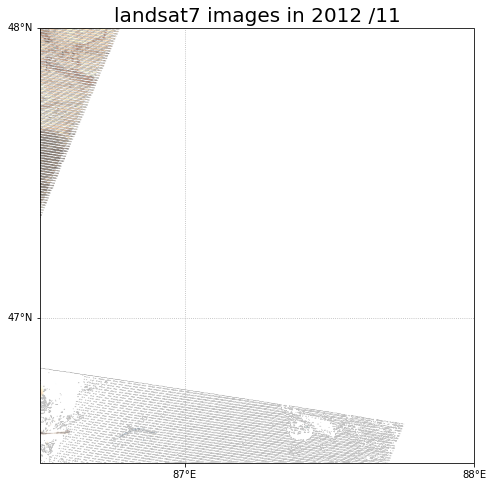

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [85,46,94,51.5]  
region = [86.5,46.5,88,48] 

for month in range(10,12,1):
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(cloudMaskL457) 
    fig = plt.figure(figsize=(12, 8))
    altay_landsat = landsat_images.mosaic().clip(Altay)
    # 添加图层到Map中
    Map.addLayer(altay_landsat,visParams7,'Uvs image in {} month'.format(month))
    ax = cartoee.get_map(altay_landsat, region=region, vis_params=visParams7)
    cartoee.add_gridlines(ax, interval=[1,1], linestyle=":")
    ax.set_title(label = 'landsat7 images in {} /{}'.format(Year,month), fontsize=20)

##  计算在可用月份，湖泊的水体面积

In [ ]:
# 根据上一步，Landsat影像在湖泊上的覆盖范围，确定需要提取水体面积的月份
# 如：需要提取水体面积的月份为5，6，8月，则 yue = [5,6,8]
yue = [10]

In [ ]:
print('landsat7 {} Year: '.format(Year))
for month in yue:
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(cloudMaskL457) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(cloudMaskL457) 
    altay_landsat = landsat_images.mosaic().clip(Altay).select(bands7).rename(bands8)
    Map.addLayer(altay_landsat,visParams8,'image in {} month'.format(month))
    altay_water = AWEIsh(altay_landsat).select('AWEI').gt(0).selfMask()
    Map.addLayer(altay_water,{'palette':['blue']},'altay water {}'.format(month))
    water_vector = altay_water.reduceToVectors(scale=30, maxPixels=1000000000)
    altay_lake = water_vector.filterBounds(roi)
    Map.addLayer(altay_lake,{},"uvs {}".format(month))
    altay_waterarea = altay_lake.map(calculate_area)
    print('area:{} km² in {} month'.format(altay_waterarea.first().get('area').getInfo(),month))

# landsat8 2013.05-2020.12

##  一些变量的自定义

In [ ]:
# 设置影像的年份，可用年份为2014-2020
Year = 2014
# 定义一些变量
days_31 = [1,3,5,7,8,10,12]
days_30 = [4,6,9,11]
days_28 = [2]

In [ ]:
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                 .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)
visParams8 = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

## 显示每个月份landsat8影像覆盖范围

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [85,46,94,51.5]  
region = [86.5,46.5,88,48] 

for month in range(1,13,1):
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(maskL8sr) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(maskL8sr) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(maskL8sr) 
    fig = plt.figure(figsize=(12, 8))
    altay_landsat = landsat_images.mosaic().clip(Altay)
    # 添加图层到Map中
    Map.addLayer(altay_landsat,visParams8,'image in {} month'.format(month))
    ax = cartoee.get_map(altay_landsat, region=region, vis_params=visParams8)
    cartoee.add_gridlines(ax, interval=[1,1], linestyle=":")
    ax.set_title(label = 'landsat8 images in {} /{}'.format(Year,month), fontsize=20)

##  计算在可用月份，湖泊的水体面积

In [ ]:
# 根据上一步，Landsat影像在湖泊上的覆盖范围，确定需要提取水体面积的月份
# 如：需要提取水体面积的月份为5，6，8月，则 yue = [5,6,8]
yue = [7,8,9,10]

In [ ]:
print('landsat8 {} Year: '.format(Year))
for month in yue:
    if month in days_31:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-31'.format(Year,month)) \
            .map(maskL8sr) 
    elif month in days_30:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-30'.format(Year,month)) \
            .map(maskL8sr) 
    elif month in days_28:
        landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterBounds(Altay) \
            .filterDate('{}-{}-01'.format(Year,month), '{}-{}-28'.format(Year,month)) \
            .map(maskL8sr) 
    altay_landsat = landsat_images.mosaic().clip(Altay)
    Map.addLayer(altay_landsat,visParams8,'image in {} month'.format(month))
    altay_water = AWEIsh(altay_landsat).select('AWEI').gt(0).selfMask()
    Map.addLayer(altay_water,{'palette':['blue']},'altay water {}'.format(month))
    water_vector = altay_water.reduceToVectors(scale=30, maxPixels=1000000000)
    altay_lake = water_vector.filterBounds(roi)
    Map.addLayer(altay_lake,{},"uvs {}".format(month))
    altay_waterarea = altay_lake.map(calculate_area)
    print('area:{} km² in {} month'.format(altay_waterarea.first().get('area').getInfo(),month))